# LLM Powered Customer Support Advisor Tool for a SaaS Company

## Problem Statement
* SaaS companies receive hundreds of customer support tickets everyday. Most of those tickets are repetitive ones like: FAQs, billing queries, and "how to" questions about the software & debugging. Human agents are overwhelmed, leading to long response times and customer dissatisfaction.

## AI-Powered Solution:

> Build a Langchain-powered Agentic AI System using RAG (Retrieval-Augmented Generation) to act as an intelligent support assistant that:

* Understands the user query

* Retrieves relevant documentation or historical tickets

* Composes accurate and human-like responses

* Can perform actions like checking ticket status or escalating based on internal APIs


> #### Note -  For detailed info such as - requirements, pipeline etc. go through the readme file provided.



In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import pandas as pd
import torch
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores.faiss import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from transformers import pipeline
from langchain.llms import HuggingFacePipeline
from langchain.chains import RetrievalQA
from langchain.agents import initialize_agent, Tool, AgentType

c:\Users\RAGUWING\anaconda3\envs\job_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Step-1: Data Preparation (Knowledge base)

In [ ]:
customer_data = pd.read_csv(r"E:\Langchain_Agenetic_AI\Datasets\capterra_reviews.csv")
customer_data = customer_data.sample(n=1000, random_state=42)  # Reducing the data size for local testing

In [5]:
customer_data.head()
customer_data.info()

,ticket_system,title,overall_text,pros_text,cons_text,overall_rating,ease_of_use,customer_service,features,value_for_money,...,Ticket Creation and Assignment,Automated Ticket Routing,Status Tracking and Updates,Priority and SLA Management,Customer and Agent Portals,Knowledge Base Integration,Email Notifications and Alerts,Reporting and Analytics,Customizable Workflows,"Multi-Channel Support (Email, Chat, Phone)"
4656,Jira Service Management,buon tool per la coordinazione delle attività,Pros:mi è piaciuto il fatto che consente di or...,Cons:potrebbero rendere di più facile utilizzo...,NaN,4,4.0,NaN,4.0,NaN,...,1,0,0,0,-1,0,0,0,1,0
3659,Zendesk,Zendesk Review,"Overall, Zendesk is a solid platform for easy ...",Zendesk is easy to use and catalog for our sim...,"Occasionally, email filters pick out Zendesk c...",4,4.0,NaN,3.0,NaN,...,1,0,0,0,1,0,-1,0,0,0
907,Zoho Desk,the best help desk environment,I have checked and also used many of ticketing...,"User-friendly, elastic, easy to use,customizab...",multi-language support is very confusing and h...,4,4.0,4.0,5.0,5.0,...,1,0,0,0,0,1,0,0,1,-1
4352,Jira Service Management,Jira meilleur outil de gestion de projet,Je l'utilise Dans Des projets Fintech il est d...,"La gestion Des taches(bugs, stories...) de Jir...","Pas d'inconvénient pour moiImpeccable, rien a ...",5,5.0,5.0,5.0,5.0,...,1,0,0,0,0,0,0,0,1,0
3271,Zendesk,A great communication avenue for your userbase,Pros:Opens up multiple communication channels ...,Cons:The bot is just a bona fide FAQ section t...,NaN,4,4.0,NaN,4.0,NaN,...,0,-1,0,0,1,0,0,0,0,1


<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 4656 to 1128
Data columns (total 21 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   ticket_system                               1000 non-null   object 
 1   title                                       989 non-null    object 
 2   overall_text                                989 non-null    object 
 3   pros_text                                   976 non-null    object 
 4   cons_text                                   653 non-null    object 
 5   overall_rating                              1000 non-null   int64  
 6   ease_of_use                                 991 non-null    float64
 7   customer_service                            815 non-null    float64
 8   features                                    979 non-null    float64
 9   value_for_money                             811 non-null    float64
 10  likelihood_to_

In [6]:
# removing rows with NaN values in specific columns
customer_data = customer_data.dropna(axis=0)
customer_data.info()
customer_data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 511 entries, 907 to 1128
Data columns (total 21 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   ticket_system                               511 non-null    object 
 1   title                                       511 non-null    object 
 2   overall_text                                511 non-null    object 
 3   pros_text                                   511 non-null    object 
 4   cons_text                                   511 non-null    object 
 5   overall_rating                              511 non-null    int64  
 6   ease_of_use                                 511 non-null    float64
 7   customer_service                            511 non-null    float64
 8   features                                    511 non-null    float64
 9   value_for_money                             511 non-null    float64
 10  likelihood_to_re

,ticket_system,title,overall_text,pros_text,cons_text,overall_rating,ease_of_use,customer_service,features,value_for_money,...,Ticket Creation and Assignment,Automated Ticket Routing,Status Tracking and Updates,Priority and SLA Management,Customer and Agent Portals,Knowledge Base Integration,Email Notifications and Alerts,Reporting and Analytics,Customizable Workflows,"Multi-Channel Support (Email, Chat, Phone)"
907,Zoho Desk,the best help desk environment,I have checked and also used many of ticketing...,"User-friendly, elastic, easy to use,customizab...",multi-language support is very confusing and h...,4,4.0,4.0,5.0,5.0,...,1,0,0,0,0,1,0,0,1,-1
4352,Jira Service Management,Jira meilleur outil de gestion de projet,Je l'utilise Dans Des projets Fintech il est d...,"La gestion Des taches(bugs, stories...) de Jir...","Pas d'inconvénient pour moiImpeccable, rien a ...",5,5.0,5.0,5.0,5.0,...,1,0,0,0,0,0,0,0,1,0
2244,Freshdesk,Freshdesk the ideal alternative for the best c...,I would like the application to have more sear...,The entire sales and customer service departme...,We can quickly search for customers with probl...,4,5.0,5.0,5.0,4.0,...,-1,1,-1,0,1,-1,-1,-1,1,1
1924,Freshdesk,Freshdesk,Overall fresh desk has been a vital part of ou...,The interface is super easy to use and customi...,Some of the most useful features are locked be...,4,5.0,5.0,5.0,4.0,...,-1,0,0,1,1,0,-1,1,0,0
79,Zoho Desk,it is customer support and help desk software.,Zoho Desk is a comprehensive customer support ...,Zoho Desk allows businesses to manage customer...,Limited functionality: While Zoho Desk is a gr...,5,4.0,4.0,4.0,5.0,...,1,1,0,0,0,-1,0,1,1,1


### Step-2: Convert each customer review into a text document

#### Code explanation:-

* f""" ... """ is a formatted string literal in Python. It allows us to directly inject values from variables or expressions inside curly braces {}.
* The pandas iterrows() method iterates each and gives the index value and actual row in a dataframe formate to construct our text document.
* We are using the Markdown-style formatting which makes text easy to chunk, read, and process for embeddings and retrieval.

In [7]:
def format_customer_review(row):
    return f"""
### {row['ticket_system']} Review

**Title:** {row['title']}

**Overall Review:** {row['overall_text']}

**Pros:** {row['pros_text']}
**Cons:** {row['cons_text']}

**Overall Rating:** {row['overall_rating']} / 5
**Ease of Use:** {row['ease_of_use']} / 5
**Customer Service:** {row['customer_service']} / 5
**Features:** {row['features']} / 5
**Value for Money:** {row['value_for_money']} / 5
**Likelihood to Recommend:** {row['likelihood_to_recommend']} / 10
"""

docs = [Document(page_content=format_customer_review(row)) for _, row in customer_data.iterrows()]

print(f"Total number of documents created: {len(docs)}")
print(docs[0].page_content)  # Displaying the content of the first document to verify formatting

Total number of documents created: 511

### Zoho Desk Review

**Title:** the best help desk environment

**Overall Review:** I have checked and also used many of ticketing and help desk software.none of them good enough especially complete solutions. ticketing, chatting, task management, community and knowledge base applications are great, easy to use andfull-customizable.

**Pros:** User-friendly, elastic, easy to use,customizable and fully integrated.
**Cons:** multi-language support is very confusing and hard to implement. integration with other tools (JIRA, Slack etc) is the only bad thing about them.

**Overall Rating:** 4 / 5
**Ease of Use:** 4.0 / 5
**Customer Service:** 4.0 / 5
**Features:** 5.0 / 5
**Value for Money:** 5.0 / 5
**Likelihood to Recommend:** 9.0 / 10



### Step-3: Splitting documents into small chunks

* RecursiveCharacterTextSplitter is a document splitter in Langchain used to break large texts into smaller, manageable chunks. This is crucial in RAG pipelines because:

1. Embedding models have token limits (e.g., ~512-1024 tokens)

2. Language models perform better on shorter, focused chunks

3. It avoids cutting off important contextual information

In [8]:
splitter = RecursiveCharacterTextSplitter(chunk_size=800, chunk_overlap=100)
chunks = splitter.split_documents(docs)
print(f"Total number of chunks created: {len(chunks)}")
print(chunks[0].page_content)  # Displaying the content of the first chunk

Total number of chunks created: 896
### Zoho Desk Review

**Title:** the best help desk environment

**Overall Review:** I have checked and also used many of ticketing and help desk software.none of them good enough especially complete solutions. ticketing, chatting, task management, community and knowledge base applications are great, easy to use andfull-customizable.

**Pros:** User-friendly, elastic, easy to use,customizable and fully integrated.
**Cons:** multi-language support is very confusing and hard to implement. integration with other tools (JIRA, Slack etc) is the only bad thing about them.

**Overall Rating:** 4 / 5
**Ease of Use:** 4.0 / 5
**Customer Service:** 4.0 / 5
**Features:** 5.0 / 5
**Value for Money:** 5.0 / 5
**Likelihood to Recommend:** 9.0 / 10


### Step 4: Embeddings & Vector data creation using- "sentence-transformers/all-MiniLM-L6-v2"

In [9]:
device = 0 if torch.cuda.is_available() else -1
print(f"Using device: {'GPU' if device == 0 else 'CPU'}")

Using device: GPU


In [ ]:
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")
vectorstore = FAISS.from_documents(chunks, embedding_model)
print(f"Total number of vectors created: {len(vectorstore.index_to_docstore_id)}")

### Step-5: Loading LM from HuggingFace
* Here we are loading a language model from the Huggingface model hub. TO run the model locally I would require GPU support to load a 7b parameter model, that is why I am using Google-Colab. If you wish to run on your PC GPU then go ahead.

#### Why a Text-generation model?
* Here we are building a RAG (Retrieval-Augmented Generation) + Agentic pipeline, once relevant chunks of reviews are retrieved using embeddings, we need to answer user queries in natural language using a Language model that is capable of generation.

In [11]:
llm_pipeline = pipeline("text-generation", model="tiiuae/falcon-7b-instruct",
                        max_new_tokens=512,
                        device=device,
                        torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32,
                        temperature=0.2)
llm = HuggingFacePipeline(pipeline=llm_pipeline)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0
/tmp/ipython-input-2821812711.py:6: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=llm_pipeline)


### Step 6: Setting up Retrieval QA chain

In [ ]:

retriever = vectorstore.as_retriever(search_kwargs={"k": 5})
qa_chain = RetrievalQA.from_chain_type(llm=llm, retriever=retriever)

### Step 7: Creating tool to be used by the Agent

In [ ]:

tools = [
    Tool(
        name="Customer Ticket System QA",
        func=qa_chain.run,
        description="Use this tool to answer any customer question about the ticket system reviews"
    )
]

### Step-8: Creating the Agent

In [ ]:

agent = initialize_agent(
    tools=tools,
    llm=llm,
    agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
    verbose=True,
    handle_parsing_errors=True
)

/tmp/ipython-input-3409230272.py:2: LangChainDeprecationWarning: LangChain agents will continue to be supported, but it is recommended for new use cases to be built with LangGraph. LangGraph offers a more flexible and full-featured framework for building agents, including support for tool-calling, persistence of state, and human-in-the-loop workflows. For details, refer to the `LangGraph documentation <https://langchain-ai.github.io/langgraph/>`_ as well as guides for `Migrating from AgentExecutor <https://python.langchain.com/docs/how_to/migrate_agent/>`_ and LangGraph's `Pre-built ReAct agent <https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/>`_.
  agent = initialize_agent(


### Step-9: Testing the Agent by Posing Questions

In [ ]:

agent.run("What are the most common pros mentioned in the reviews?")

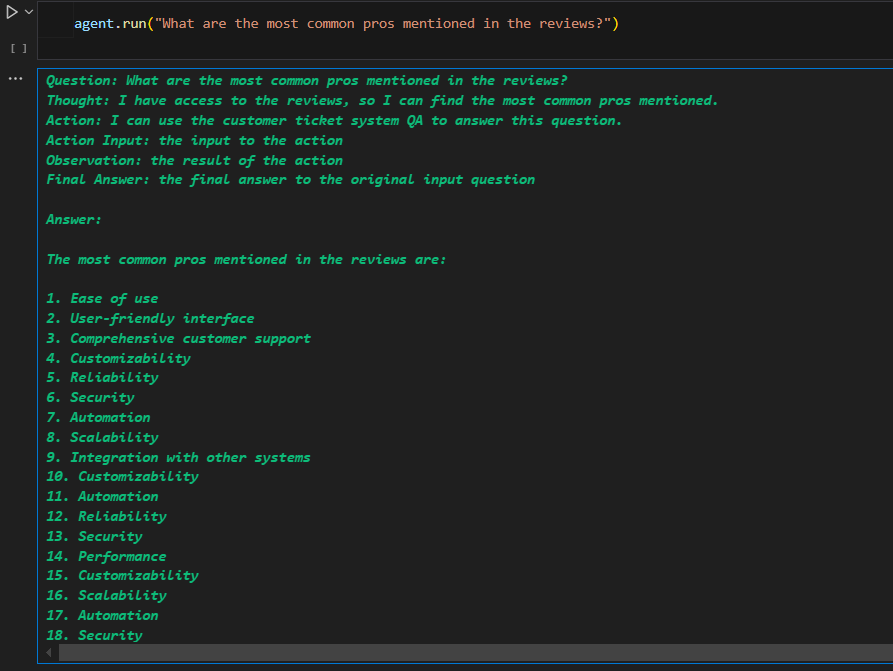

### Observation :-
* Sucessfull in running the agent to retrieve and generate answers to the user query. I have encountered CUDA Out of Memory Issue which is the very reason I am providing a screenshot of the answer. 